# Compare photometry in the new and old Stripe82 catalogs

[Link to helper tools](#dataTools) 

[Link to data reading](#dataReading) 

[Link to data analysis](#dataAnalysis) 

In [1]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import numpy as np
from astroML.plotting import hist
# for astroML installation see https://www.astroml.org/user_guide/installation.html

<a id='dataTools'></a>

### Helper Tools

In [2]:
### selection tools and numerical analysis 

# robust standard deviation
def sigG(arr):
    return 0.741*(np.quantile(arr, 0.75)-np.quantile(arr, 0.25))

def checkNobs(d, band):
    str1 = band + '_Nobs_old'
    arr1 = d[str1]
    print(band, 'band, OLD:')
    printStats(arr1)
    str1 = band + '_Nobs_new'
    arr1 = d[str1]
    print('        NEW:')
    printStats(arr1)
    print('      DIFF:')
    str2 = 'd' + band
    arr2 = d[str2]
    printStats(arr2)
    return
  
def printStats(arr):
    print('           ', np.min(arr), np.median(arr), np.max(arr)) 
    return 

# given vectors x and y, fit medians in bins from xMin to xMax, with Nbin steps,
# and return xBin, medianBin, medianErrBin 
def fitMedians(x, y, xMin, xMax, Nbin, verbose=1): 

    # first generate bins
    xEdge = np.linspace(xMin, xMax, (Nbin+1)) 
    xBin = np.linspace(0, 1, Nbin)
    nPts = 0*np.linspace(0, 1, Nbin)
    medianBin = 0*np.linspace(0, 1, Nbin)
    sigGbin = -1+0*np.linspace(0, 1, Nbin) 
    for i in range(0, Nbin): 
        xBin[i] = 0.5*(xEdge[i]+xEdge[i+1]) 
        yAux = y[(x>xEdge[i])&(x<=xEdge[i+1])]
        if (yAux.size > 0):
            nPts[i] = yAux.size
            medianBin[i] = np.median(yAux)
            # robust estimate of standard deviation: 0.741*(q75-q25)
            sigmaG = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,25))
            # uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
            sigGbin[i] = np.sqrt(np.pi/2)*sigmaG/np.sqrt(nPts[i])
        else:
            nPts[i] = 0
            medianBin[i] = 0
            sigGbin[i] = 0
        
    if (verbose):
        print('median:', np.median(medianBin[nPts>0]), 'std.dev:', np.std(medianBin[nPts>0]))

    return xBin, nPts, medianBin, sigGbin

In [3]:
### plots 

# quick plot 
def qp(d, Xstr, Xmin, Xmax, Ystr, Ymin, Ymax):
    ax = plt.axes()
    ax.set_xlabel(Xstr)
    ax.set_ylabel(Ystr)
    ax.scatter(d[Xstr], d[Ystr], s=0.01, c='blue')  
    ax.set_xlim(Xmin, Xmax)
    ax.set_ylim(Ymin, Ymax)
    plt.show()
    return

# quick plot - compare three subsamples
def qp3(d1, d2, d3, Xstr, Xmin, Xmax, Ystr, Ymin, Ymax):
    ax = plt.axes()
    ax.set_xlabel(Xstr)
    ax.set_ylabel(Ystr)
    ax.scatter(d1[Xstr], d1[Ystr], s=0.01, c='green') 
    ax.scatter(d2[Xstr], d2[Ystr], s=0.01, c='red') 
    ax.scatter(d3[Xstr], d3[Ystr], s=0.01, c='blue') 
    ax.set_xlim(Xmin, Xmax)
    ax.set_ylim(Ymin, Ymax)
    plt.show()
    return

# quick plot - binned median
def qpBM(d, Xstr, Xmin, Xmax, Ystr, Ymin, Ymax, nBin, Nsigma=3, offset=0.01):
    ax = plt.axes()
    ax.scatter(d[Xstr], d[Ystr], s=0.01, c='black') 
    # binning
    xBinM, nPtsM, medianBinM, sigGbinM = fitMedians(d[Xstr], d[Ystr], Xmin, Xmax, nBin, 1)
    # plotting
    ax.scatter(xBinM, medianBinM, s=30.0, c='black', alpha=0.8)
    ax.scatter(xBinM, medianBinM, s=15.0, c='yellow', alpha=0.3)
    #
    TwoSigP = medianBinM + Nsigma*sigGbinM
    TwoSigM = medianBinM - Nsigma*sigGbinM 
    ax.plot(xBinM, TwoSigP, c='yellow')
    ax.plot(xBinM, TwoSigM, c='yellow')
    #
    rmsBin = np.sqrt(nPtsM) / np.sqrt(np.pi/2) * sigGbinM
    rmsP = medianBinM + rmsBin
    rmsM = medianBinM - rmsBin
    ax.plot(xBinM, rmsP, c='cyan')
    ax.plot(xBinM, rmsM, c='cyan')
    # 
    xL = np.linspace(-100,100)
    ax.plot(xL, 0*xL+offset, c='red')
    ax.plot(xL, 0*xL-offset, c='red')
    # 
    ax.set_xlabel(Xstr)
    ax.set_ylabel(Ystr)
    ax.set_xlim(Xmin, Xmax)
    ax.set_ylim(Ymin, Ymax)
    plt.show()
    return
 
def qphist(arr, xMin, xMax, xLabel, verbose = False):
    ax = plt.axes()
    hist(arr, bins='knuth', ax=ax, histtype='stepfilled', ec='k', fc='#AAAAAA')
    ax.set_xlabel(xLabel)
    ax.set_ylabel('n')
    ax.set_xlim(xMin, xMax)
    plt.show()
    if (verbose):
        print('Min, max: ', np.min(arr),np.max(arr)) 
        print('Mean, median: ', np.mean(arr),np.median(arr)) 
        print('sigG, st.dev.: ', sigG(arr),np.std(arr)) 
    return 

def qpH0(arr, xMin, xMax, xLabel, nBins=0, verbose = False):
    ax = plt.axes()
    if (nBins>0):
        hist, bins = np.histogram(arr, bins=nBins)
        center = (bins[:-1]+bins[1:])/2
        ax.plot(center, hist, drawstyle='steps', c='blue')   
    else:
        plt.hist(arr, bins='auto', histtype='stepfilled', ec='k', fc='red') 
 
    ax.set_xlabel(xLabel)
    ax.set_ylabel('n')
    ax.set_xlim(xMin, xMax)
    ax.plot([-1000, 1000], [0, 0], '--k')
    plt.show()
    if (verbose):
        print('Min, max: ', np.min(arr),np.max(arr)) 
        print('Mean, median: ', np.mean(arr),np.median(arr)) 
        print('sigG, st.dev.: ', sigG(arr),np.std(arr))  
    return 

def qpHdm(d, band, dmMax, xMin, xMax, nBins=50, verbose=False):
    str = 'd' + band
    dm = 1000*d[str]
    dmOK = dm[np.abs(dm)<(1000*dmMax)]
    xLabel = str + ' (milimag)'
    qpH0(dmOK, 1000*xMin, 1000*xMax, xLabel, nBins, verbose)
    return np.mean(dmOK), np.median(dmOK), sigG(dmOK)


def qp2hist(arr1, arr2, xMin, xMax, xLabel, nBins=0, verbose = False):
    ax = plt.axes()
    if (nBins>0):
        hist, bins = np.histogram(arr1, bins=nBins)
        center = (bins[:-1]+bins[1:])/2
        ax.plot(center, hist, drawstyle='steps', c='red')   
        hist2, bins2 = np.histogram(arr2, bins=nBins)
        center2 = (bins2[:-1]+bins2[1:])/2
        ax.plot(center2, hist2, drawstyle='steps', c='blue')   
    else:
        plt.hist(arr1, bins='auto', histtype='stepfilled', ec='k', fc='yellow')
        plt.hist(arr2, bins='auto', histtype='stepfilled', ec='red', fc='blue')
 
    ax.set_xlabel(xLabel)
    ax.set_ylabel('n')
    ax.set_xlim(xMin, xMax)
    plt.show()
    if (verbose):
        print('Min: ', np.min(arr1),np.min(arr2)) 
        print('Median: ', np.median(arr1),np.median(arr2)) 
        print('sigG: ', sigG(arr1),sigG(arr2)) 
        print('Max: ', np.max(arr1),np.max(arr2)) 
    return 

<a id='dataReading'></a>

### Define paths and catalogs 

In [4]:
ZIdataDir = "/Users/ivezic/Work/Science/CalibrationV2/Data"
# the original SDSS catalog from 2007
sdssOldCat = ZIdataDir + "/" + "stripe82calibStars_v2.6.dat"
# Karun's new catalog from 2020
sdssNewCat = ZIdataDir + "/" + "NEW_stripe82calibStars_v0.dat" 

In [5]:
# both new and old files use identical data structure
colnamesSDSS = ['calib_fla', 'ra', 'dec', 'raRMS', 'decRMS', 'nEpochs', 'AR_val', 
                'u_Nobs', 'u_mMed', 'u_mMean', 'u_mErr', 'u_rms_scatt', 'u_chi2',
                'g_Nobs', 'g_mMed', 'g_mMean', 'g_mErr', 'g_rms_scatt', 'g_chi2',
                'r_Nobs', 'r_mMed', 'r_mMean', 'r_mErr', 'r_rms_scatt', 'r_chi2',
                'i_Nobs', 'i_mMed', 'i_mMean', 'i_mErr', 'i_rms_scatt', 'i_chi2',
                'z_Nobs', 'z_mMed', 'z_mMean', 'z_mErr', 'z_rms_scatt', 'z_chi2']

In [6]:
%%time
# old
sdssOld = Table.read(sdssOldCat, format='ascii', names=colnamesSDSS) 
np.size(sdssOld)

CPU times: user 23.3 s, sys: 4.61 s, total: 27.9 s
Wall time: 27.2 s


1006849

In [7]:
%%time
# new 
sdssNewRaw = Table.read(sdssNewCat, format='csv', names=colnamesSDSS)
# rejects objects with bad Declination, sample size from 1007136 to 1005470 
sdssNew = sdssNewRaw[sdssNewRaw['dec']<90]
np.size(sdssNew)

CPU times: user 7.68 s, sys: 1.53 s, total: 9.21 s
Wall time: 8.3 s


1005470

#### Simple positional match using ra/dec

In [8]:
sdssOld_coords = SkyCoord(ra = sdssOld['ra']*u.degree, dec= sdssOld['dec']*u.degree) 
sdssNew_coords = SkyCoord(ra = sdssNew['ra']*u.degree, dec= sdssNew['dec']*u.degree) 
# this is matching sdssNew to sdssOld, so that indices are into sdssNew catalog
# makes sense in this case since the sdssOld catalog is (a little bit) bigger 
# than sdssNew (1006849 vs 1005470)
idx, d2d, d3d = sdssNew_coords.match_to_catalog_sky(sdssOld_coords)  

In [9]:
# object separation is an object with units, 
# I add that as a column so that one can 
# select based on separation to the nearest matching object
new_old = hstack([sdssNew, sdssOld[idx]], table_names = ['new', 'old'])
new_old['sep_2d_arcsec'] = d2d.arcsec
# since we matched sdssNew to sdssOld, the resulting catalog has the same lengthas sdssNew: 1005470

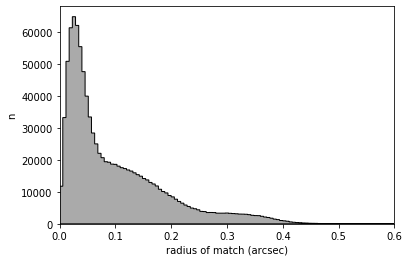

Min, max:  4.31952298377011e-05 9.932391913810758
Mean, median:  0.10594934216107652 0.06585489334585509
sigG, st.dev.:  0.08365484416960975 0.19906836591921895


In [10]:
qphist(d2d.arcsec, 0.0, 0.6, 'radius of match (arcsec)', True)

### Select good matches and compare new vs. old magnitudes

In [11]:
## first limit astrometric distance and 
## require at least 4 epochs as in the old catalog
MAX_DISTANCE_ARCSEC = 0.5
m1 = new_old[(new_old['sep_2d_arcsec'] < MAX_DISTANCE_ARCSEC)]
a1 = m1['g_Nobs_new']
a2 = m1['r_Nobs_new']
a3 = m1['i_Nobs_new']
mOK = m1[(a1>3)&(a2>3)&(a3>3)]
print(len(new_old))
print(len(m1))
print(len(mOK))

1005470
1003204
1002094


In [12]:
## additional constraints for the u and z band:
## require at least 4 epochs both in the old and new catalogs 
mOKu = mOK[(mOK['u_Nobs_old']>3)&(mOK['u_Nobs_new']>3)]
mOKz = mOK[(mOK['z_Nobs_old']>3)&(mOK['u_Nobs_new']>3)]
print(len(mOK))
print(len(mOKu))
print(len(mOKz))

1002094
535079
999546


In [13]:
### code for generating new quantities, such as dra, ddec, colors, differences in mags, etc
def derivedColumns(matches):
    matches['dra'] = (matches['ra_new']-matches['ra_old'])*3600
    matches['ddec'] = (matches['dec_new']-matches['dec_old'])*3600
    matches['ra'] = matches['ra_old']
    ra = matches['ra'] 
    matches['raW'] = np.where(ra > 180, ra-360, ra) 
    matches['dec'] = matches['dec_old']
    matches['u'] = matches['u_mMed_old']
    matches['g'] = matches['g_mMed_old']
    matches['r'] = matches['r_mMed_old']
    matches['i'] = matches['i_mMed_old']
    matches['z'] = matches['z_mMed_old']
    matches['ug'] = matches['u_mMed_old'] - matches['g_mMed_old']
    matches['gr'] = matches['g_mMed_old'] - matches['r_mMed_old']
    matches['ri'] = matches['r_mMed_old'] - matches['i_mMed_old']
    matches['gi'] = matches['g_mMed_old'] - matches['i_mMed_old']
    matches['du'] = matches['u_mMed_old'] - matches['u_mMed_new']
    matches['dg'] = matches['g_mMed_old'] - matches['g_mMed_new']
    matches['dr'] = matches['r_mMed_old'] - matches['r_mMed_new']
    matches['di'] = matches['i_mMed_old'] - matches['i_mMed_new']
    matches['dz'] = matches['z_mMed_old'] - matches['z_mMed_new']
    return

In [14]:
derivedColumns(mOK)
derivedColumns(mOKu)
derivedColumns(mOKz)

#### A few sanity checks plots...

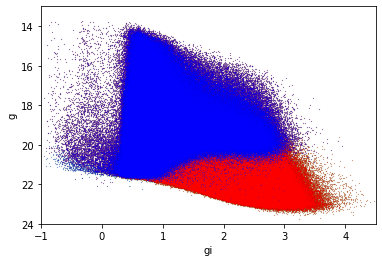

In [15]:
qp3(mOK, mOKz, mOKu, 'gi', -1.0, 4.5, 'g', 24, 13)

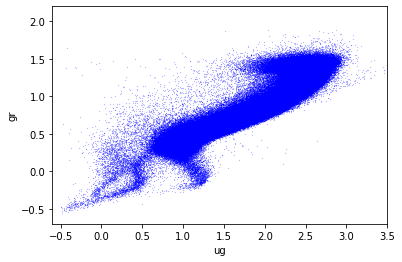

In [16]:
qp(mOKu, 'ug', -0.6, 3.5, 'gr', -0.7, 2.2) 

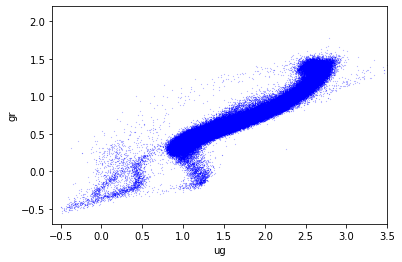

In [17]:
mOKuB = mOKu[mOKu['u']<21]
qp(mOKuB, 'ug', -0.6, 3.5, 'gr', -0.7, 2.2) 

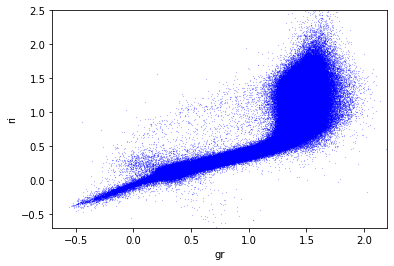

In [18]:
qp(mOK, 'gr', -0.7, 2.2, 'ri', -0.7, 2.5) 

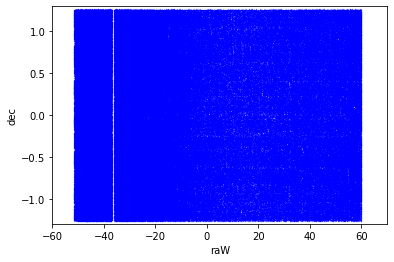

In [19]:
qp(mOK, 'raW', -60, 70, 'dec', -1.3, 1.3) 

#### Nothing weird showed up; let's now do a detailed comparison and quantify improvements

In [20]:
checkNobs(mOKu, 'u')
checkNobs(mOK, 'g')
checkNobs(mOK, 'r')
checkNobs(mOK, 'i') 
checkNobs(mOKz, 'z') 

u band, OLD:
            4 8.0 28
        NEW:
            4 17.0 95
      DIFF:
            -9999.781 -0.009000000000000341 10021.646
g band, OLD:
            4 9.0 28
        NEW:
            4.0 17.0 95.0
      DIFF:
            -7.795999999999999 -0.0010000000000012221 10022.181999999999
r band, OLD:
            4 9.0 28
        NEW:
            4 17.0 95
      DIFF:
            -6.438999999999998 0.0 10020.529
i band, OLD:
            4 9.0 28
        NEW:
            4.0 17.0 95.0
      DIFF:
            -5.803000000000001 0.0 10020.467
z band, OLD:
            4 9.0 28
        NEW:
            4 17.0 95
      DIFF:
            -5.521000000000001 -0.0019999999999988916 10020.321


In [21]:
def makeAllPlots(d, b, dmMax=0.05):
    str1 = b + '_Nobs_old'
    str2 = b + '_Nobs_new'
    str3 = 'Nobs(' + b + ')'
    str4 = 'd' + b
    qp2hist(d[str1], d[str2], 0, 50, str3,51, True)
    meanDM, medianDM, sigDM = qpHdm(d, b, 0.1, -0.1, 0.1, 50, True)
    # binned medians of dm vs. both coordinates, magnitude and color
    qpBM(d, 'raW', -51.5, 60.0, str4, -1*dmMax, dmMax, 500) 
    qpBM(d, 'dec', -1.3, 1.3, str4, -1*dmMax, dmMax, 120) 
    qpBM(d, b, 14, 23.0, str4, -1*dmMax, dmMax, 150) 
    qpBM(d, 'gi', -0.7, 3.5, str4, -1*dmMax, dmMax, 150) 
    return meanDM, medianDM, sigDM

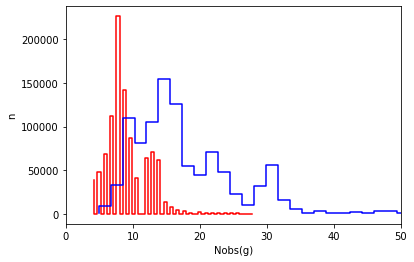

Min:  4 4.0
Median:  9.0 17.0
sigG:  2.964 6.669
Max:  28 95.0


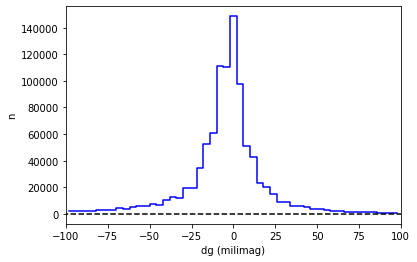

Min, max:  -99.99999999999787 99.99999999999787
Mean, median:  -2.814810614179844 -1.0000000000012221
sigG, st.dev.:  12.5969999999996 23.73633049253089
median: -0.0010000000000012221 std.dev: 0.0006742244271072361


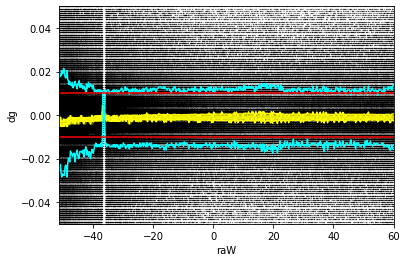

median: -0.0010000000000012221 std.dev: 0.00408632784608961


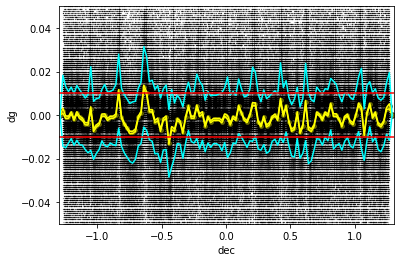

median: -0.0009999999999994458 std.dev: 0.002595936996325257


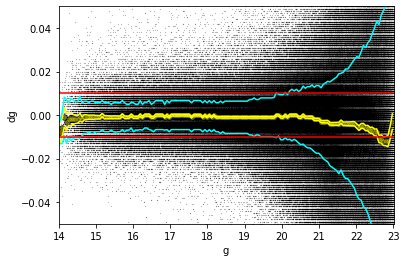

median: -0.0019999999999988916 std.dev: 0.0014430715697965003


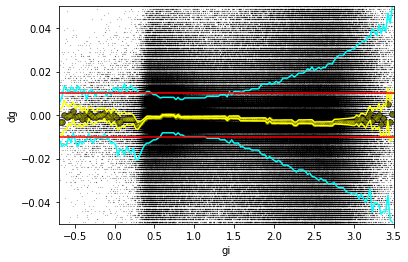

BAND g :  -2.814810614179844 -1.0000000000012221 12.5969999999996


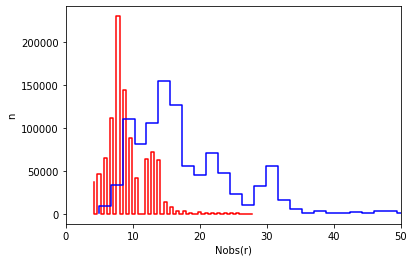

Min:  4 4
Median:  9.0 17.0
sigG:  2.964 6.669
Max:  28 95


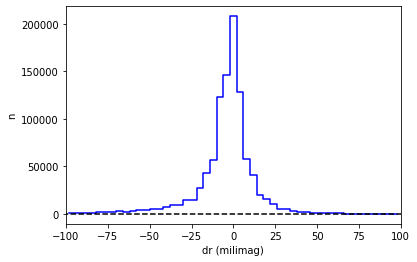

Min, max:  -99.99999999999787 99.99999999999787
Mean, median:  -2.4085837845695433 0.0
sigG, st.dev.:  8.892000000001653 17.417252441725363
median: 0.0 std.dev: 0.00048205409264624445


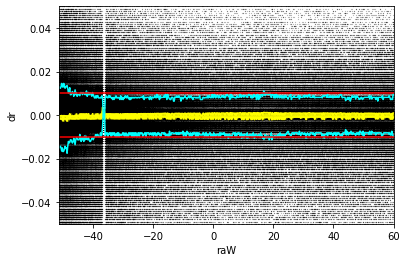

median: 0.0 std.dev: 0.0030376952852107365


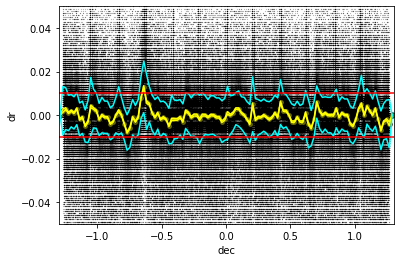

median: 0.0 std.dev: 0.00954623613923718


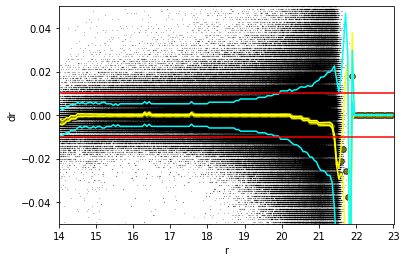

median: -0.0009999999999976694 std.dev: 0.0011077554884638776


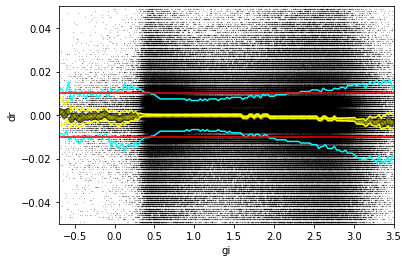

BAND r :  -2.4085837845695433 0.0 8.892000000001653


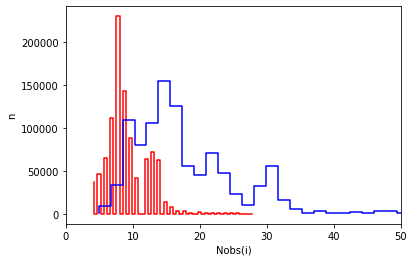

Min:  4 4.0
Median:  9.0 17.0
sigG:  2.964 6.669
Max:  28 95.0


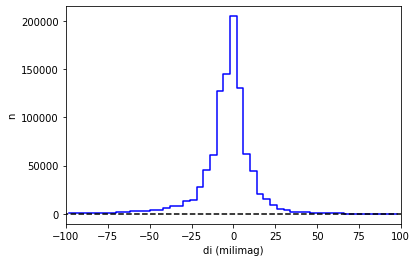

Min, max:  -99.99999999999787 99.99999999999787
Mean, median:  -1.8241031560493894 0.0
sigG, st.dev.:  8.892000000000337 15.91520033573703
median: 0.0 std.dev: 0.00041741411339426887


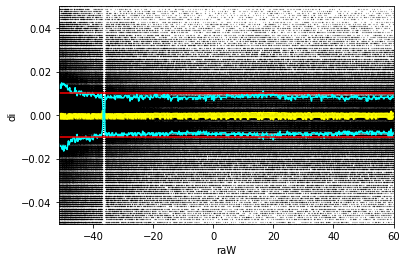

median: 0.0 std.dev: 0.0036000494745871926


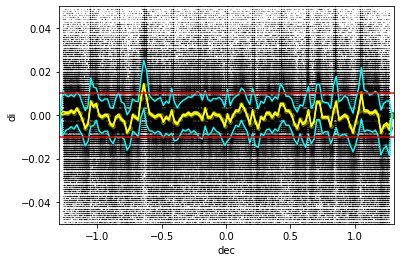

median: 0.0 std.dev: 0.014390046666800868


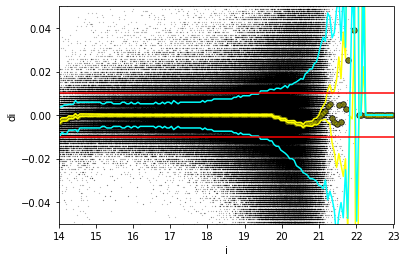

median: 0.0 std.dev: 0.0010197167362662823


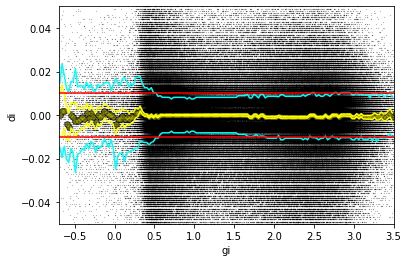

BAND i :  -1.8241031560493894 0.0 8.892000000000337


In [22]:
for b in ('g', 'r', 'i'):
    meanDM, medianDM, sigDM = makeAllPlots(mOK, b)
    print('BAND', b, ': ', meanDM, medianDM, sigDM)

In [23]:
mOKbright = mOK[mOK['g']<20.5] 

median: 0.0 std.dev: 0.003943665716286657


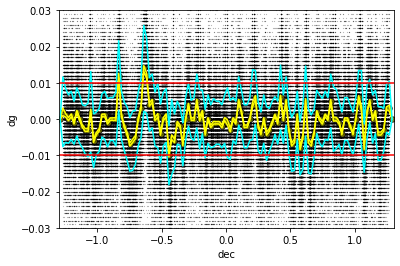

In [24]:
qpBM(mOKbright, 'dec', -1.3, 1.3, 'dg', -0.03, 0.03, 120) 

median: 0.0 std.dev: 0.0029926655531310187


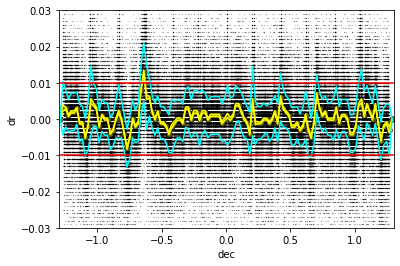

In [25]:
qpBM(mOKbright, 'dec', -1.3, 1.3, 'dr', -0.03, 0.03, 120) 

median: 0.0 std.dev: 0.003547923637469639


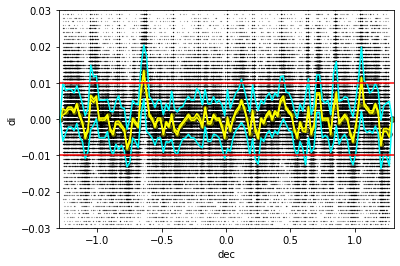

In [26]:
qpBM(mOKbright, 'dec', -1.3, 1.3, 'di', -0.03, 0.03, 120) 

In [27]:
## systematics wrt Dec look very similar in gri; check g-r and r-i systematics

In [28]:
mOKbright['dgr'] = mOKbright['dg'] - mOKbright['dr'] 
mOKbright['dri'] = mOKbright['dr'] - mOKbright['di'] 

median: -0.0009999999999976694 std.dev: 0.003125490481473624


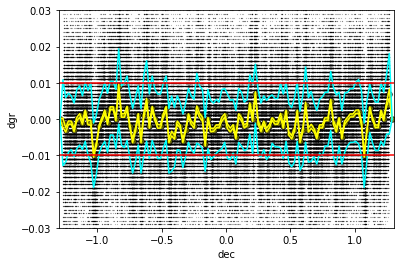

In [29]:
qpBM(mOKbright, 'dec', -1.3, 1.3, 'dgr', -0.03, 0.03, 120) 

median: 3.552713678800501e-15 std.dev: 0.002123198494528713


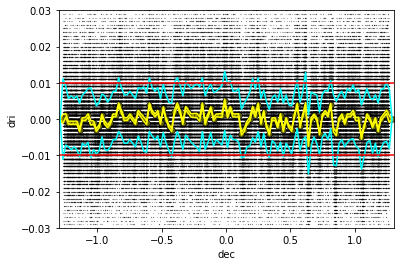

In [30]:
qpBM(mOKbright, 'dec', -1.3, 1.3, 'dri', -0.03, 0.03, 120) 

In [31]:
### CONCLUSION: need to correct for Dec systematics, at least with a gray correction 
# check also u and z bands for systematics 

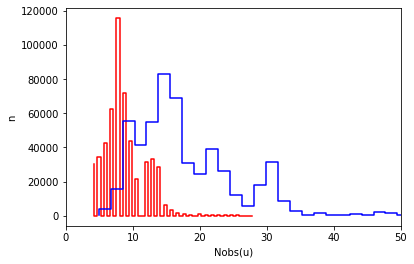

Min:  4 4
Median:  8.0 17.0
sigG:  2.964 7.41
Max:  28 95


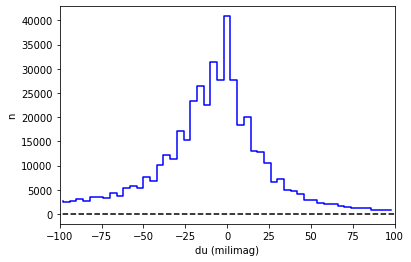

Min, max:  -99.99999999999787 99.99999999999787
Mean, median:  -7.24256843928388 -4.999999999999005
sigG, st.dev.:  25.194000000001832 32.84467395600913
median: -0.009000000000000341 std.dev: 0.002064962306050269


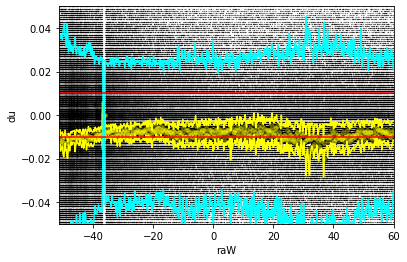

median: -0.007999999999999119 std.dev: 0.010922436840929566


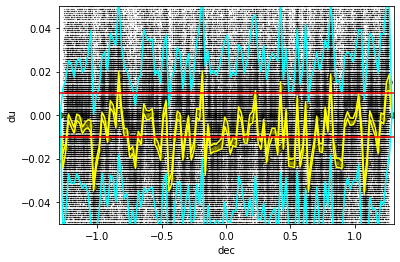

median: -0.0034999999999998366 std.dev: 0.03879281863343126


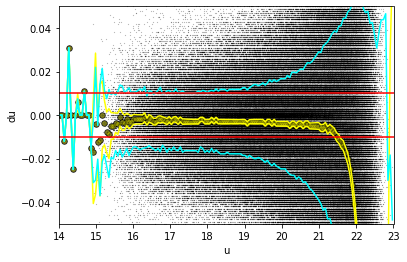

median: -0.013000000000001677 std.dev: 0.03807790260330339


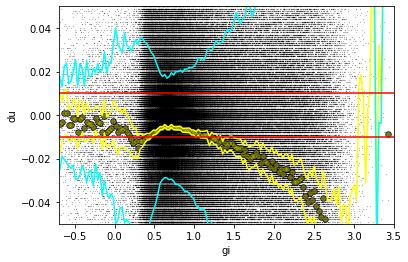

BAND u :  -7.24256843928388 -4.999999999999005 25.194000000001832


In [32]:
b = 'u'
meanDM, medianDM, sigDM = makeAllPlots(mOKu, b)
print('BAND', b, ': ', meanDM, medianDM, sigDM)

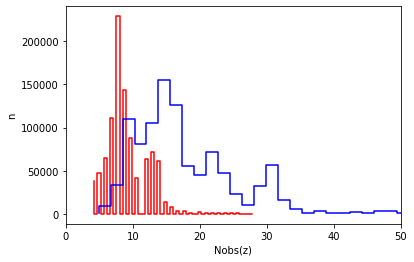

Min:  4 4
Median:  9.0 17.0
sigG:  2.964 6.669
Max:  28 95


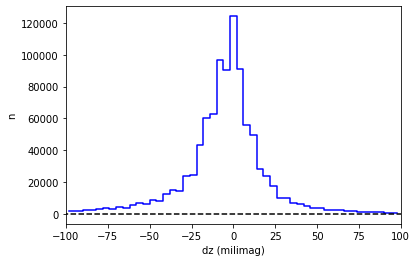

Min, max:  -99.99999999999787 99.99999999999787
Mean, median:  -3.2584597239065083 -1.0000000000012221
sigG, st.dev.:  15.560999999997957 24.562986961982777
median: -0.0010000000000012221 std.dev: 0.0009216917080532292


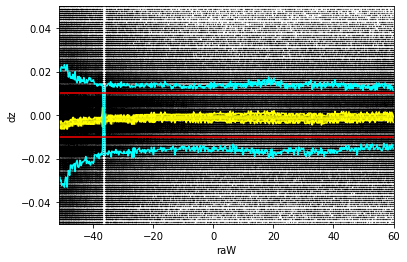

median: -0.0019999999999988916 std.dev: 0.004892915705616552


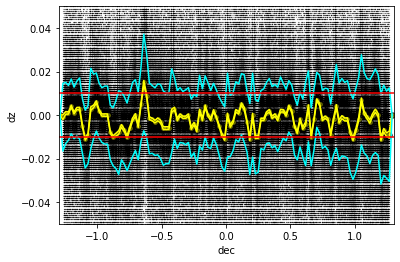

median: -0.0010000000000012221 std.dev: 0.011348146393171422


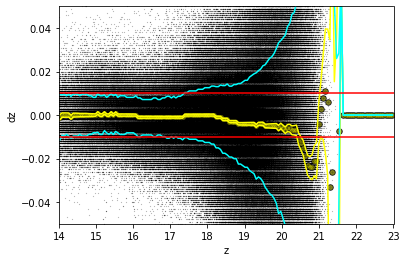

median: -0.0019999999999988916 std.dev: 0.007268421806386446


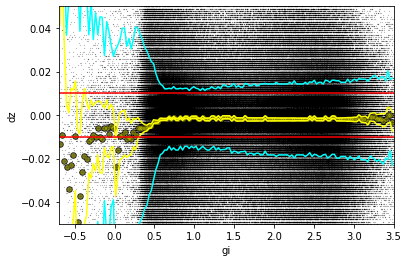

BAND z :  -3.2584597239065083 -1.0000000000012221 15.560999999997957


In [33]:
b = 'z'
meanDM, medianDM, sigDM = makeAllPlots(mOKz, b)
print('BAND', b, ': ', meanDM, medianDM, sigDM)

278999


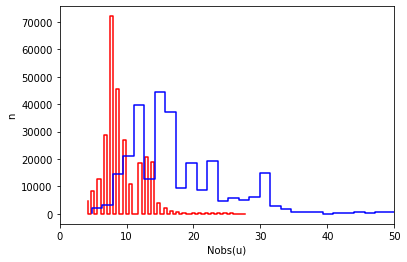

Min:  4 4
Median:  9.0 17.0
sigG:  2.223 6.669
Max:  28 84


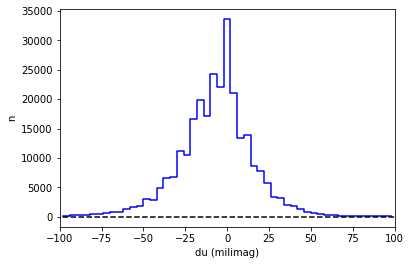

Min, max:  -99.99999999999787 99.99999999999787
Mean, median:  -4.841601581594408 -3.0000000000001137
sigG, st.dev.:  17.784000000000674 22.53623552437864
median: -0.0030000000000001137 std.dev: 0.0011088728157440631


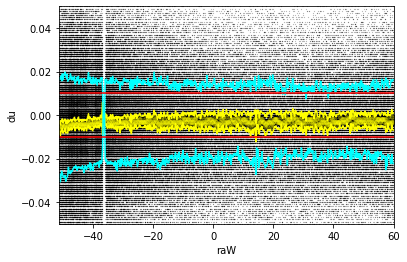

median: -0.0030000000000001137 std.dev: 0.010417074491681316


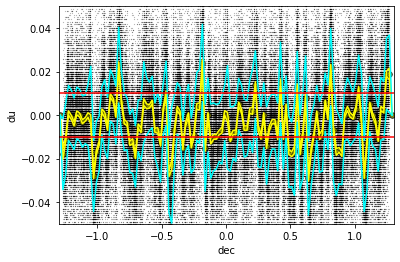

median: -0.0030000000000001137 std.dev: 0.0009096079256743052


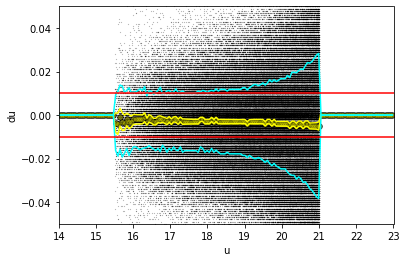

median: -0.0030000000000001137 std.dev: 0.01145421590584634


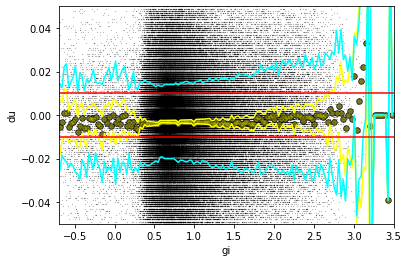

BAND u :  -4.841601581594408 -3.0000000000001137 17.784000000000674


In [35]:
## check bright end for u subsample 
mOKuB = mOKu[(mOKu['u']>15.5)&(mOKu['u']<21)]
print(np.size(mOKuB))
b = 'u'
meanDM, medianDM, sigDM = makeAllPlots(mOKuB, b)
print('BAND', b, ': ', meanDM, medianDM, sigDM)

In [43]:
## check u-g color systematics vs. Dec for bright u subsample
mOKuB['dug'] = mOKuB['du'] - mOKuB['dg']   

median: -0.0035000000000007248 std.dev: 0.008100772942362718


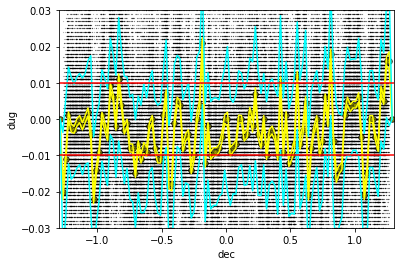

In [44]:
qpBM(mOKuB, 'dec', -1.3, 1.3, 'dug', -0.03, 0.03, 120) 

In [39]:
## check color systematics vs. Dec for bright z subsample
mOKzB = mOKz[(mOKz['z']>14)&(mOKz['z']<20)]
print(np.size(mOKzB))
mOKzB['dri'] = mOKzB['dr'] - mOKzB['di']  
mOKzB['diz'] = mOKzB['di'] - mOKzB['dz']  

869738


median: -0.0010000000000012221 std.dev: 0.004877919282233504


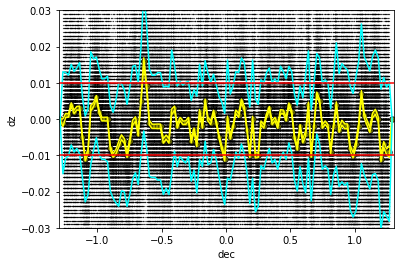

In [42]:
qpBM(mOKzB, 'dec', -1.3, 1.3, 'dz', -0.03, 0.03, 120) 

median: 0.0019999999999988916 std.dev: 0.002395852042485095


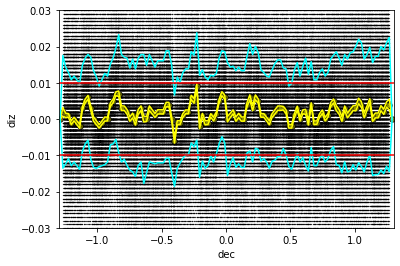

In [40]:
qpBM(mOKzB, 'dec', -1.3, 1.3, 'diz', -0.03, 0.03, 120) 

median: 0.0 std.dev: 0.0020238452114267683


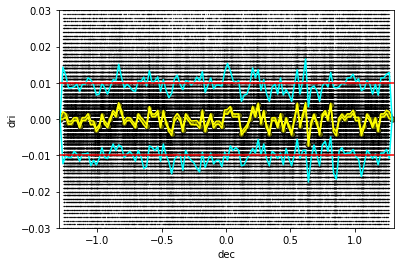

In [41]:
qpBM(mOKzB, 'dec', -1.3, 1.3, 'dri', -0.03, 0.03, 120) 